# CEE 690, Lecture 15 Code Examples

This course will make use of notebook style coding.  Notebooks are incredibly useful tools both for teaching and for disseminating data anlysis.

This is a set of codes to look at missing data.

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

This section provides some initialization commands, which can simply be copied for assignments.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# We need to import key libraries that we're going to use.  
# For now this is just numpy, which is our linear algebra library
import numpy as np

Setting the random seed for code reproducibility.

In [2]:
# to make this notebook's output stable across runs, we are going to see the random seed
np.random.seed(42)

Note that we have to reset the random seed _every_ time we run an algorithm if we want the same results!

We also want to set up a plotting environment and make it look pretty.  For those of you familiar with matlab, we will be using matplotlib which is fairly close in syntax and feel.  It's not too far off from R either.

In [3]:
# To plot pretty figures
import matplotlib.pyplot as plt
%matplotlib inline 
# This command figures show up in the notebook.  It's a "magic" command...
# Typically, this now happens by default so it is often an unnecessary command, but is good for standardization.
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

These commands will help us save figures; not going to go through them so much.

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "15"

In [5]:
# makes the directory if it doesn't exist.
import os
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory didn\'t exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.') 

Figure directory exists.


In [6]:
# a simple defined helper function.
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf',transparent=True)

## Synthetically make missing data
This will match the MCAR assumption.

In [7]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [8]:
X_original=cancer.data
y=cancer.target

This is a helper function that will randomly remove entries from our dataset.  This simulates a "Missing Completely at Random" procedure.

In [9]:
def simulate_mcar(X_original,what_percentage_to_remove=.10,random_state=42):
    np.random.seed(random_state)
    missing_entries=np.random.rand(X_original.size)<\
        what_percentage_to_remove
    X=X_original.copy()
    missing_entries=missing_entries.reshape(X_original.shape)
    X[missing_entries]=np.NaN
    return X, missing_entries

In [10]:
X,missing_entries=simulate_mcar(X_original,what_percentage_to_remove=.50)
print(X)

[[      nan 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01       nan]
 [2.057e+01       nan       nan ...       nan       nan       nan]
 [      nan       nan 1.300e+02 ... 2.430e-01 3.613e-01       nan]
 ...
 [1.660e+01       nan 1.083e+02 ...       nan 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ...       nan 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01       nan ... 0.000e+00 2.871e-01 7.039e-02]]


Let's try some initial imputation strategies.

In [11]:
from sklearn import impute
?impute.SimpleImputer

Init signature:
impute.SimpleImputer(
    ['missing_values=nan', "strategy='mean'", 'fill_value=None', 'verbose=0', 'copy=True'],
)
Docstring:     
Imputation transformer for completing missing values.

Read more in the :ref:`User Guide <impute>`.

Parameters
----------
missing_values : number, string, np.nan (default) or None
    The placeholder for the missing values. All occurrences of
    `missing_values` will be imputed.

strategy : string, optional (default="mean")
    The imputation strategy.

    - If "mean", then replace missing values using the mean along
      each column. Can only be used with numeric data.
    - If "median", then replace missing values using the median along
      each column. Can only be used with numeric data.
    - If "most_frequent", then replace missing using the most frequent
      value along each column. Can be used with strings or numeric data.
    - If "constant", then replace missing values with fill_value. Can be
      used with strings or nume

Let's make a pipeline and evaluate it on the data.

In [12]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import pipeline
from sklearn import metrics

First we will use a strategy where we replace all missing values with the mean of that feature.

In [13]:
fill_in_missing_values=impute.SimpleImputer(missing_values=np.NaN,strategy='mean')
clf=linear_model.LogisticRegression(solver='sag',tol=.01,max_iter=500)
pipe=pipeline.Pipeline(\
    [('imputation',fill_in_missing_values),\
    ('Logistic Regression',clf)])

First with the original dataset:

In [14]:
folds=model_selection.KFold(n_splits=10,random_state=42)
scores_across_folds=\
    model_selection.cross_val_score(pipe,\
    X_original,y,scoring='roc_auc',cv=folds)
print(np.mean(scores_across_folds))

0.9368943682879856


Then with missing values:

In [15]:
folds=model_selection.KFold(n_splits=10,random_state=42)
scores_across_folds=\
    model_selection.cross_val_score(pipe,\
    X,y,scoring='roc_auc',cv=folds)
print(np.mean(scores_across_folds))

0.7216813346601392


How does the level of missingness affect performance?

In [16]:
n_levels=25
percent_missing=np.linspace(0,.99,n_levels)
imputation_types=['mean','median']
mean_aucs=np.zeros([n_levels,len(imputation_types)])
folds=model_selection.KFold(n_splits=5,random_state=42)
for i in range(0,n_levels):
    for j in range(0,2):
        X,missing_entries=simulate_mcar(X_original,\
            what_percentage_to_remove=percent_missing[i])
        fill_in_missing_values=impute.SimpleImputer(strategy=imputation_types[j])
        clf=linear_model.LogisticRegression(solver='sag',tol=.01,max_iter=500)
        our_pipeline=pipeline.Pipeline(\
            [('imputation',fill_in_missing_values),\
            ('Logistic Regression',clf)])
        scores_across_folds=\
            model_selection.cross_val_score(our_pipeline,\
            X,y,scoring='roc_auc',cv=folds)
        mean_aucs[i,j]=np.mean(scores_across_folds)
    

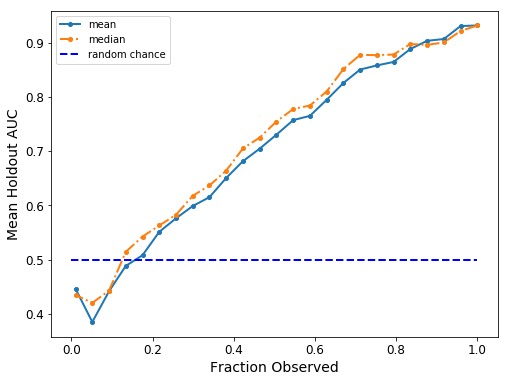

In [17]:
fig=plt.figure(figsize=[8,6])
plt.plot(1-percent_missing,mean_aucs[:,0],'.-',lw=2,ms=8,label='mean')
plt.plot(1-percent_missing,mean_aucs[:,1],'.-.',lw=2,ms=8,label='median')
plt.plot([0,1],[.5,.5],'--b',lw=2,label='random chance')
plt.legend()
plt.xlabel('Fraction Observed')
plt.ylabel('Mean Holdout AUC')
plt.show()

Some caveats here: level of penalization should vary with the level of missingness, which can enhance performance a bit.

## Collaborative Filter

Below is code to solve the low-rank object described in class.  We won't be going through the details of this algorithm, but I highly encourage you to explore on your own.

I altered this code to work as a sklearn-type object.

In [18]:
import scipy as sp
class alt_least_squares():
    max_iter=None
    k=3
    lambda_=.1
    W=None
    S=None
    losses=None
    def __init__(self, max_iter=100,k=3,lambda_=.1):
        self.max_iter=max_iter
        self.k=3
        self.lambda_=lambda_
    def loss(self,A,X,S,W):
        return np.sum(A*(X-S.dot(W.T))**2)+\
            self.lambda_*(np.sum(S**2)+np.sum(W**2))
    def fit(self,X_in):
        X=X_in.copy()
        A=~np.isnan(X)
        X[np.isnan(X)]=0
        lambda_=self.lambda_
        k=self.k
        S=np.random.randn(X.shape[0],k)
        W=np.random.randn(X.shape[1],k)
        losses=[]
        for iter in range(0,self.max_iter):
            # Loop Over S
            #print('updating S')
            i=0
            for x,a in zip(X,A):
                S[i,:]=np.linalg.solve(lambda_*np.eye(k)+W[a,:].T.dot(W[a,:]),\
                                  W.T.dot(a*x))
                i+=1
            #print('updating W')
            # Loop Over W
            i=0
            for x,a in zip(X.T,A.T):
                W[i,:]=np.linalg.solve(lambda_*np.eye(k)+S[a,:].T.dot(S[a,:]),\
                                  S.T.dot(a*x))
                i+=1
            #print('updating loss')
            losses.append(self.loss(A,X,S,W))
        #print('saving variables')
        self.losses=losses
        self.W=W
        self.S=S
        return None
        
    def transform(self,X_in):
        X=X_in.copy()
        A=~np.isnan(X)
        X[np.isnan(X)]=0
        lambda_=self.lambda_
        k=self.k
        W=self.W
        S=np.zeros([X.shape[0],k])
        i=0
        for x,a in zip(X,A):
            S[i,:]=np.linalg.solve(lambda_*np.eye(k)+W[a,:].T.dot(W[a,:]),\
                                  W.T.dot(a*x))
            i+=1
        self.S=S
        Xpred=self.S.dot(self.W.T)
        X[~A]=Xpred[~A]
        return X
        

Let's figure out what movies people like!

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tags = pd.read_table('data/movielens_small/tags.csv',delimiter=',')
ratings = pd.read_table('data/movielens_small/ratings.csv',delimiter=',')
movies = pd.read_table('data/movielens_small/movies.csv',delimiter=',')
movie_titles = movies.title.tolist()

Let's show what is in the actual data.

In [20]:
ratings[:5]

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [21]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

The next step will create the large matrix like we talked about in class.

In [22]:
rp = ratings.pivot_table(columns=['movieId'],index=['userId'],values='rating')
rp.head()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           NaN     NaN     4.0     NaN     NaN     NaN     NaN     NaN   

movieId  9       10       ...    161084  161155  161594  161830  161918  \
userId                    ...                                             
1           NaN     NaN   ...       NaN     NaN     NaN     NaN     NaN   
2           NaN     4.0   ...       NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN   ...       NaN     NaN     NaN     NaN     NaN   
4           NaN     4.0   ...       NaN     NaN     NaN     NaN     NaN   
5           NaN     NaN   ...       NaN     NaN     NaN     NaN     NaN   

movieId  161944  162376  162542  162672  163949  
userId                                           
1           NaN     NaN     NaN     NaN     NaN  
2           NaN     NaN     NaN     NaN     NaN  
3           NaN     NaN     NaN     NaN     NaN  
4           NaN     NaN     NaN     NaN     NaN  
5           NaN     NaN     NaN     NaN     NaN  

[5 rows x 9066 columns]

My code is only designed to work with NumPy arrays, so we need to conver from the datafram to an array.

In [23]:
movie_ratings=rp.values

Let's impute missing values!

In [24]:
als=alt_least_squares(max_iter=10,k=10,lambda_=.1)
als.fit(movie_ratings)
predicted_ratings=als.transform(movie_ratings)

In [25]:
print(predicted_ratings[:5])

[[ 2.53004813  2.57118971  2.03668498 ... -2.36099066 -1.4165944
  -2.83829328]
 [ 3.50963724  3.39351576  2.92190878 ... -0.73385315 -0.44031189
  -1.19800626]
 [ 3.64956053  3.27411277  2.86901192 ...  0.82660726  0.49596436
   0.42462189]
 [ 4.94850929  4.2690498   3.94160682 ...  3.32010468  1.99206281
   2.94031473]
 [ 3.84577154  3.88729631  4.         ...  0.80671056  0.48402634
   0.50572218]]


Optimization is actually quite fast here.  We can check the optimization status by looking at the reconstruction error as a function of optimization iteration.

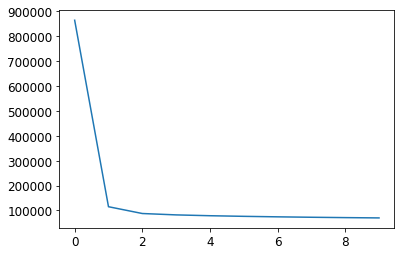

In [26]:
# visualization of the internal loop optimization
plt.plot(als.losses);

Let's find someones favorite movie!

In [27]:
i=10
m=np.where(predicted_ratings[i,:]==np.max(predicted_ratings[i,:]))[0][0]
print('This individuals favorite movie will be:')
print(movies[m:m+1])
print('And they will give it {} stars'.format(predicted_ratings[i,m]))

This individuals favorite movie will be:
      movieId                       title genres
5433     8494  Cincinnati Kid, The (1965)  Drama
And they will give it 6.447188637593524 stars


## On neurons for visualization

In [28]:
Xdf=pd.read_csv('hw3/hw3_physio.csv')
X_original=np.array(Xdf.values[:,1:],dtype=np.float64)
N=X_original.shape[0]

In [29]:
X,A=simulate_mcar(X_original,what_percentage_to_remove=.50)

In [30]:
simple_imputer=impute.SimpleImputer(strategy='mean')
simple_imputer.fit(X)
X_si=simple_imputer.transform(X)
print('mse is {}'.format(np.sum((X_si-X_original)**2)/N))
cf_imputer=alt_least_squares(k=7,lambda_=.1)
cf_imputer.fit(X)
X_cf=cf_imputer.transform(X)
print('mse is {}'.format(np.sum((X_cf-X_original)**2)/N))

mse is 17950.688306432992
mse is 10167.406294250171


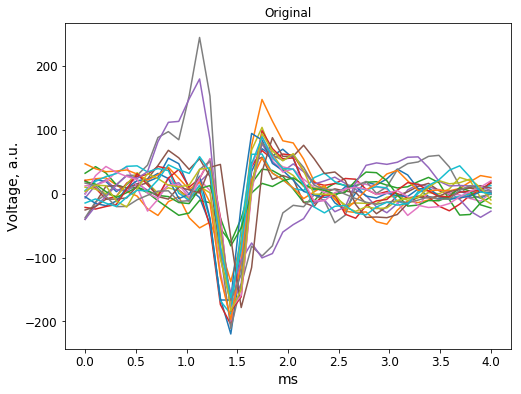

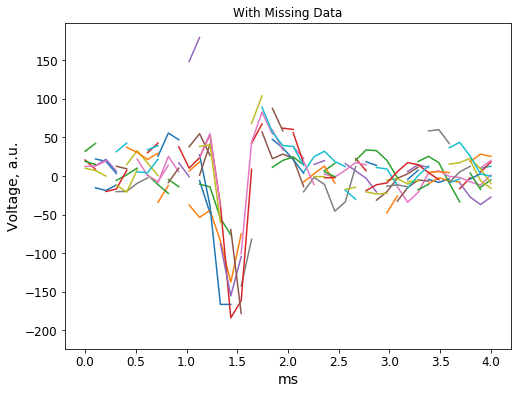

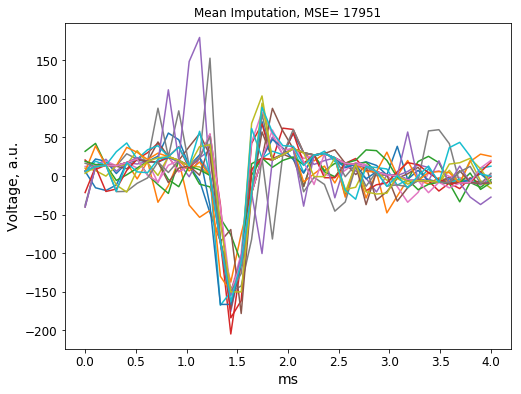

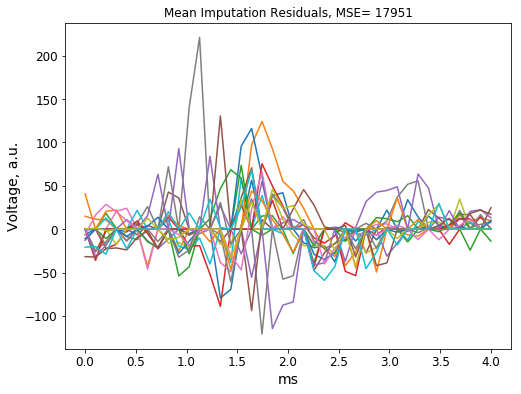

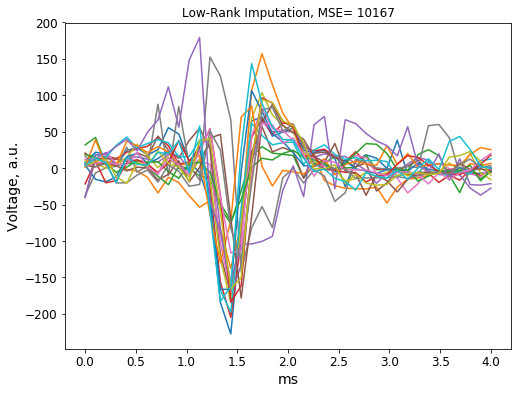

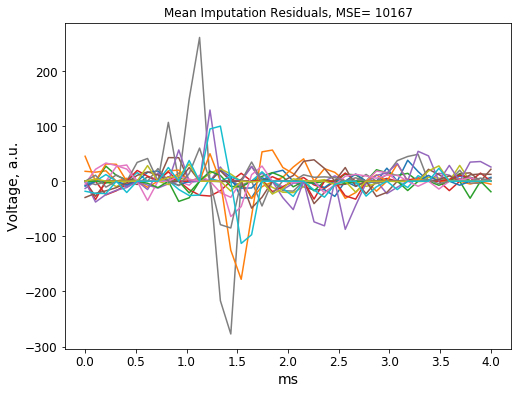

In [31]:
fig=plt.figure(figsize=[8,6])
plt.plot(np.linspace(0,4,40),X_original.T[:,:20])
plt.xlabel('ms')
plt.ylabel('Voltage, a.u.')
plt.title('Original')
plt.show()
savepdf(fig,'spikes_original')
fig=plt.figure(figsize=[8,6])
plt.plot(np.linspace(0,4,40),X.T[:,:20])
plt.xlabel('ms')
plt.ylabel('Voltage, a.u.')
plt.title('With Missing Data')
plt.show()
savepdf(fig,'spikes_missing')
fig=plt.figure(figsize=[8,6])
plt.plot(np.linspace(0,4,40),X_si.T[:,:20])
plt.xlabel('ms')
plt.ylabel('Voltage, a.u.')
plt.title('Mean Imputation, MSE={:6.0f}'.format(np.sum((X_si-X_original)**2)/N))
plt.show()
savepdf(fig,'spikes_mean_imputation')
fig=plt.figure(figsize=[8,6])
plt.plot(np.linspace(0,4,40),X_original.T[:,:20]-X_si.T[:,:20])
plt.xlabel('ms')
plt.ylabel('Voltage, a.u.')
plt.title('Mean Imputation Residuals, MSE={:6.0f}'.format(np.sum((X_si-X_original)**2)/N))
plt.show()
savepdf(fig,'spikes_mean_imputation_residual')
fig=plt.figure(figsize=[8,6])
plt.plot(np.linspace(0,4,40),X_cf.T[:,:20])
plt.xlabel('ms')
plt.ylabel('Voltage, a.u.')
plt.title('Low-Rank Imputation, MSE={:6.0f}'.format(np.sum((X_cf-X_original)**2)/N))
plt.show()
savepdf(fig,'spikes_cf')
fig=plt.figure(figsize=[8,6])
plt.plot(np.linspace(0,4,40),X_original.T[:,:20]-X_cf.T[:,:20])
plt.xlabel('ms')
plt.ylabel('Voltage, a.u.')
plt.title('Mean Imputation Residuals, MSE={:6.0f}'.format(np.sum((X_cf-X_original)**2)/N))
plt.show()
savepdf(fig,'spikes_cf_residuals')